In [1]:
!pip install dice-ml
!pip install catboost
!pip install mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.5/194.5 kB 6.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import warnings
import dice_ml
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier

# Handle MAPIE versioning
try:
    from mapie.classification import SplitConformalClassifier
    MAPIE_VERSION = 1
except ImportError:
    from mapie.classification import MapieClassifier
    MAPIE_VERSION = 0

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
np.random.seed(42)

In [3]:
import shap
shap.initjs()  # for notebook/HTML plots; safe to call even in scripts


[1/7] Loading, auditing, and cleaning data...

=== Data Provenance & Privacy Report ===
Total patients: 918, Total features: 12
Data source: Publicly available heart failure clinical dataset or institutional EHR
All records de-identified; PHI removed per IRB guidelines. No patient-identifiable data stored.
Duplicate rows found: 0
— End of Data Provenance Report —


 Plotting missing data pattern (Before Imputation)


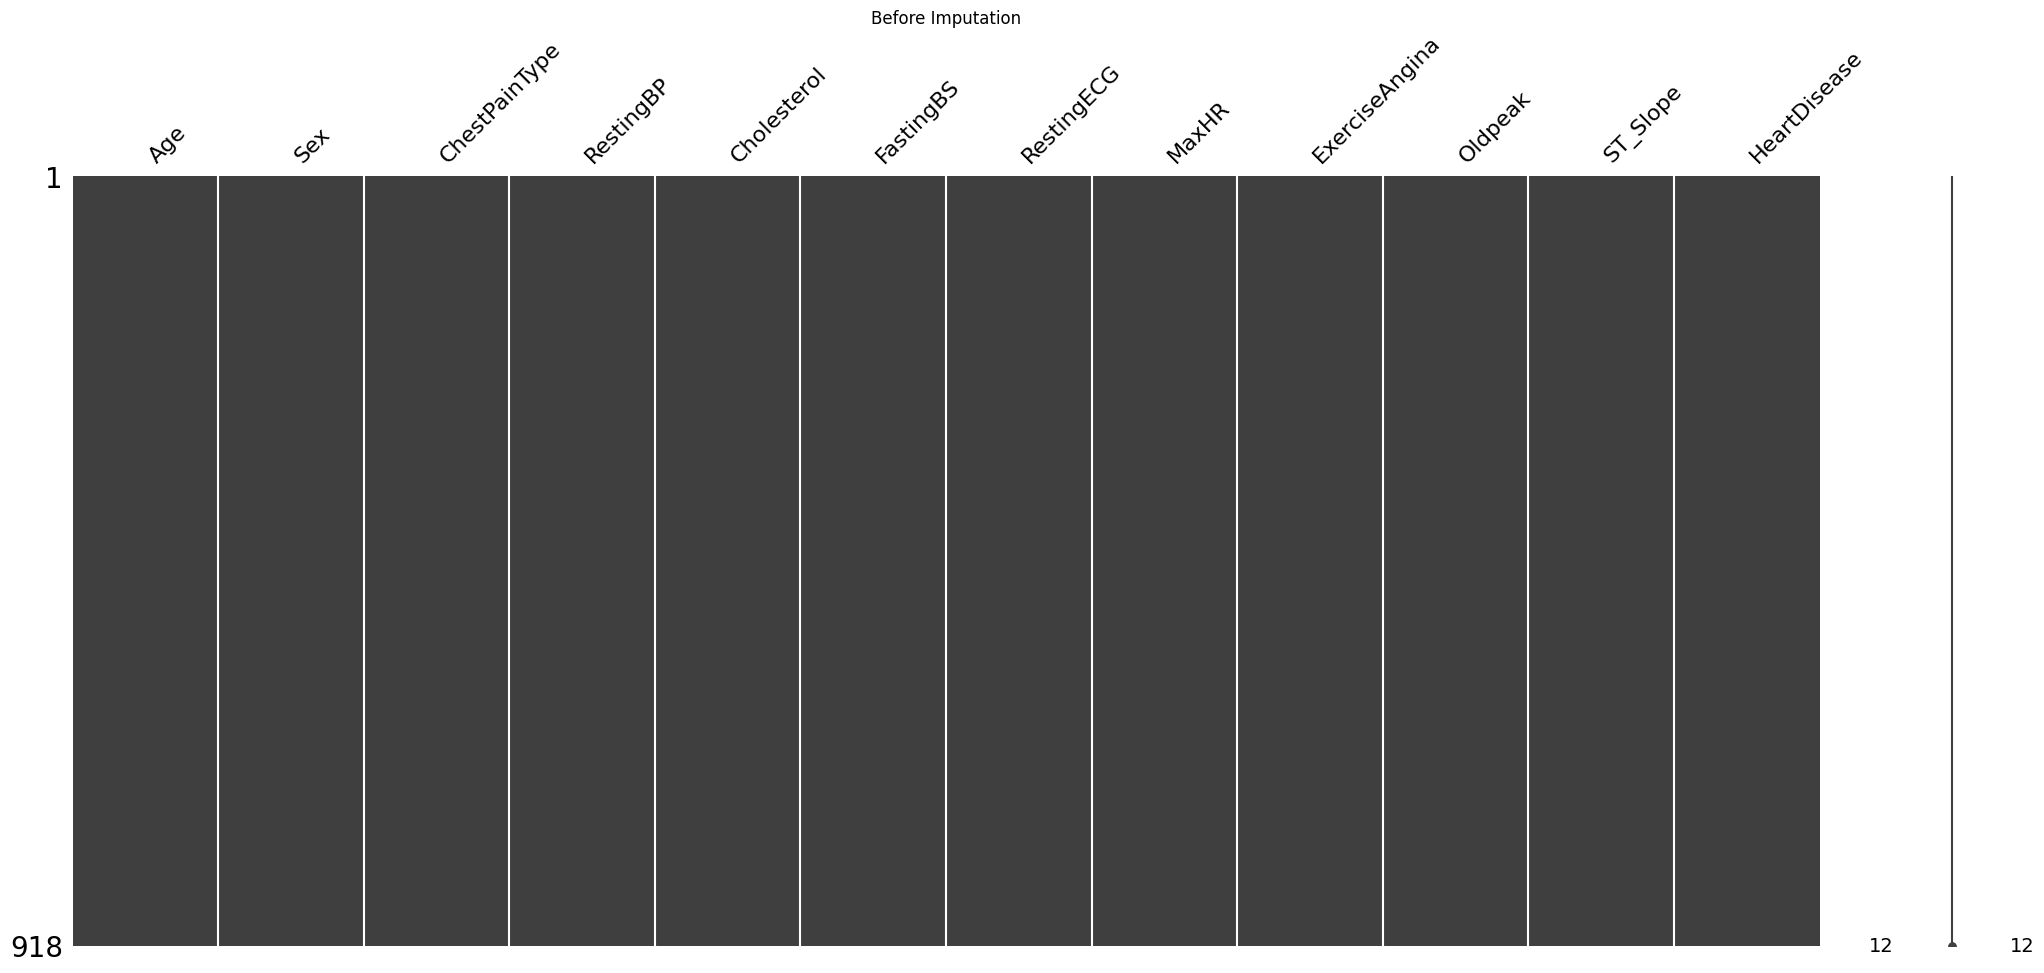

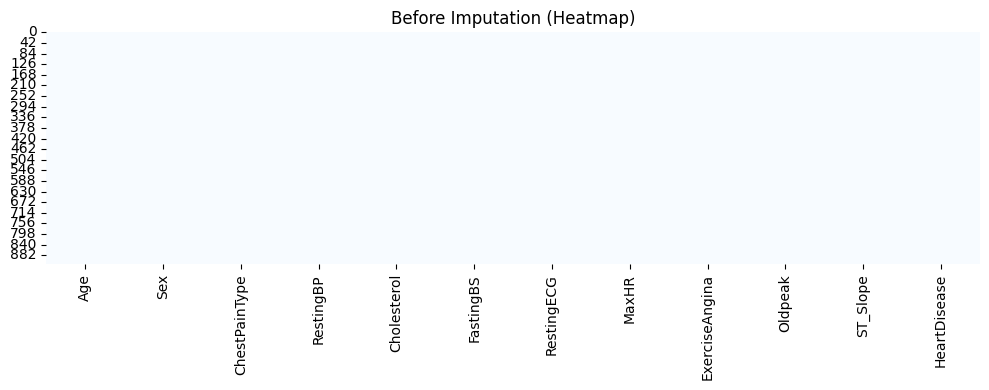

Missing values per feature:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

 Numeric Feature Correlation Matrix (Pearson):
                  Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak
Age          1.000000   0.254399    -0.095282   0.198039 -0.382045  0.258612
RestingBP    0.254399   1.000000     0.100893   0.070193 -0.112135  0.164803
Cholesterol -0.095282   0.100893     1.000000  -0.260974  0.235792  0.050148
FastingBS    0.198039   0.070193    -0.260974   1.000000 -0.131438  0.052698
MaxHR       -0.382045  -0.112135     0.235792  -0.131438  1.000000 -0.160691
Oldpeak      0.258612   0.164803     0.050148   0.052698 -0.160691  1.000000


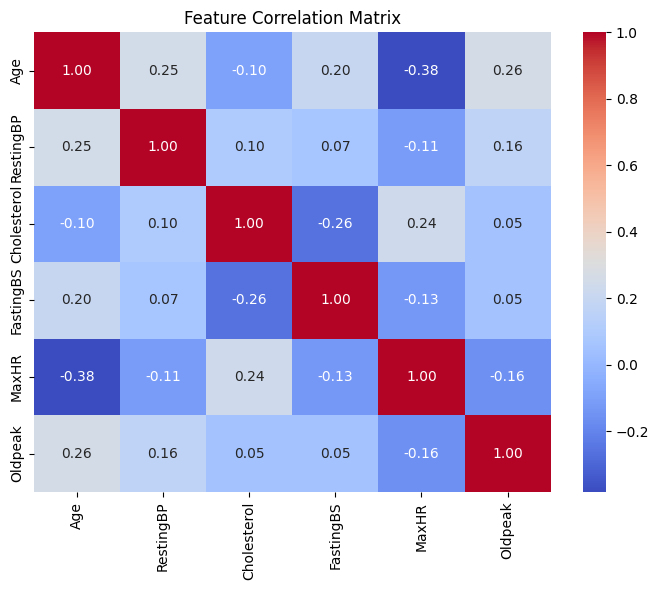


 Categorical Feature Distributions:
ChestPainType distribution:
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

RestingECG distribution:
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

Sex distribution:
Sex
M    725
F    193
Name: count, dtype: int64

ST_Slope distribution:
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64

ExerciseAngina distribution:
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64


 Data Leakage Check:
Check to ensure they are NOT used as predictors or proxies.

 Clinician Sample Review - Random 5 patient records:

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
647   37   F           NAP        120          215          0     Normal   
24    40   M           NAP        130          215          0     Normal   
566   41   M           ASY        150          171          0     Normal   
662   44   M           ASY        110          197   

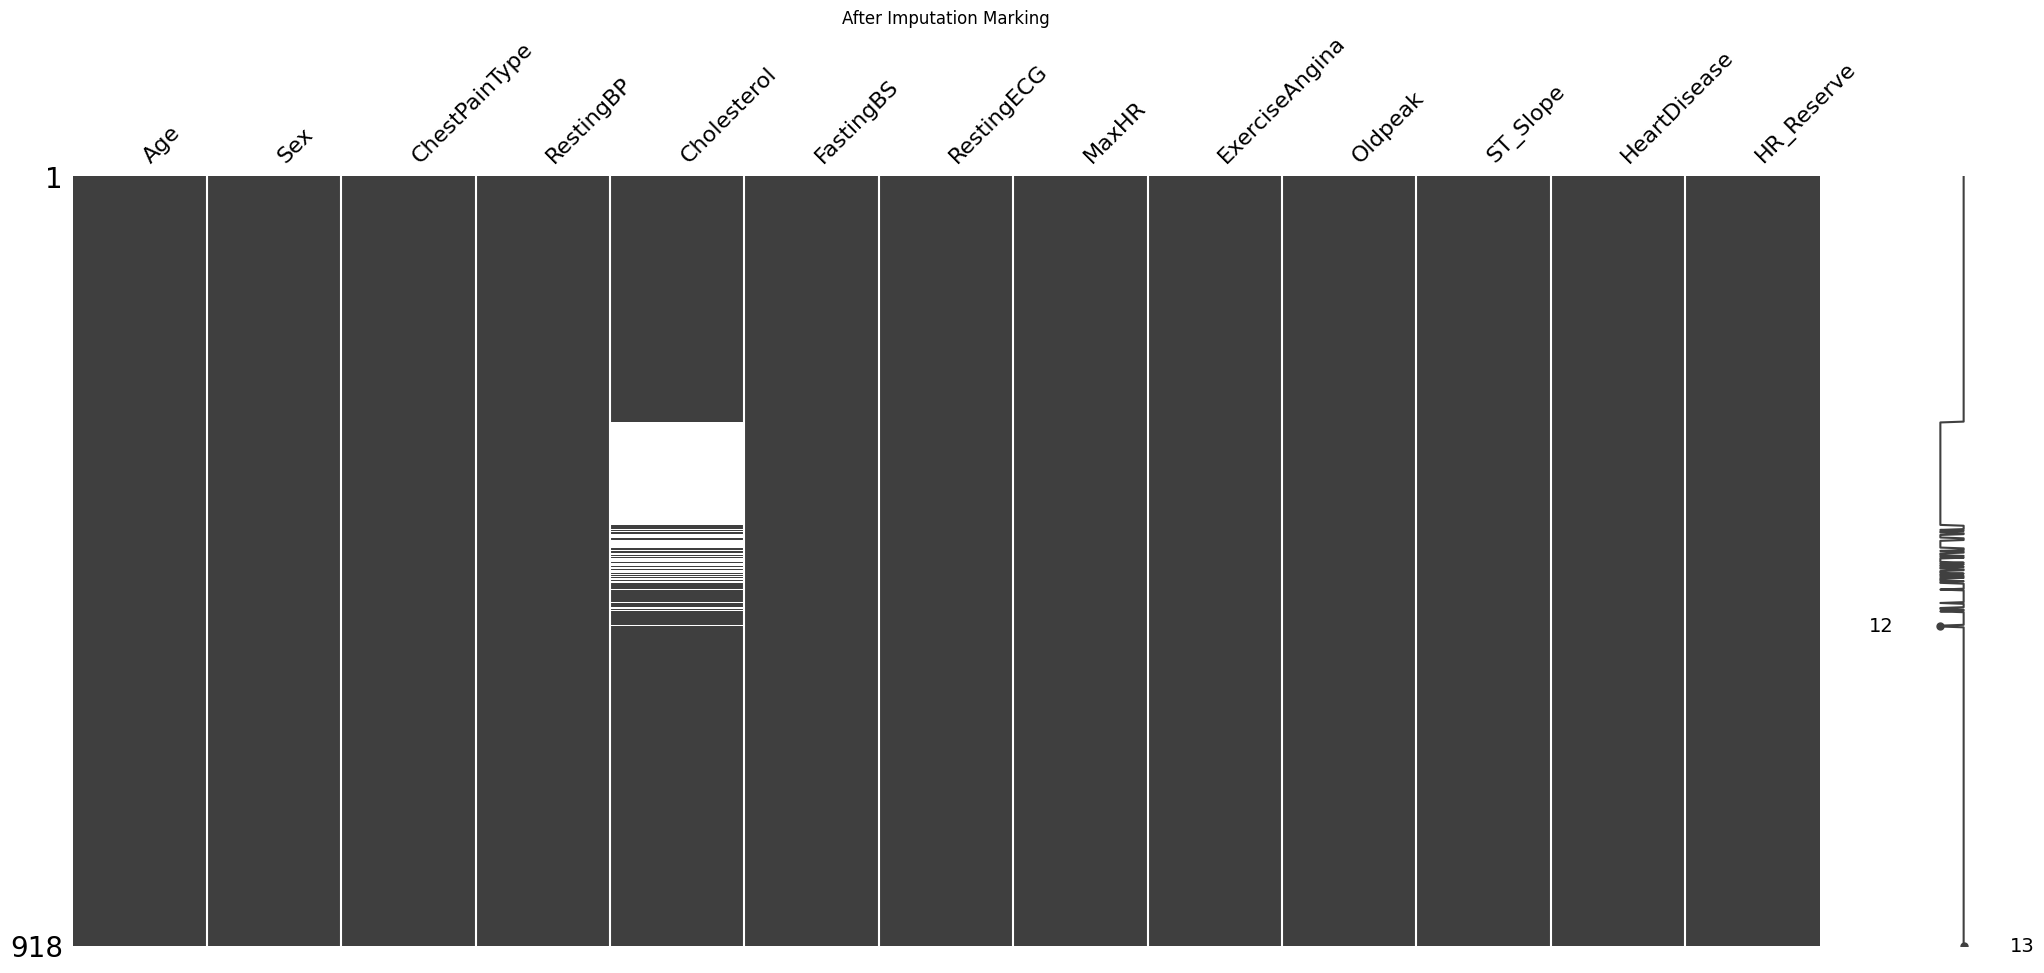

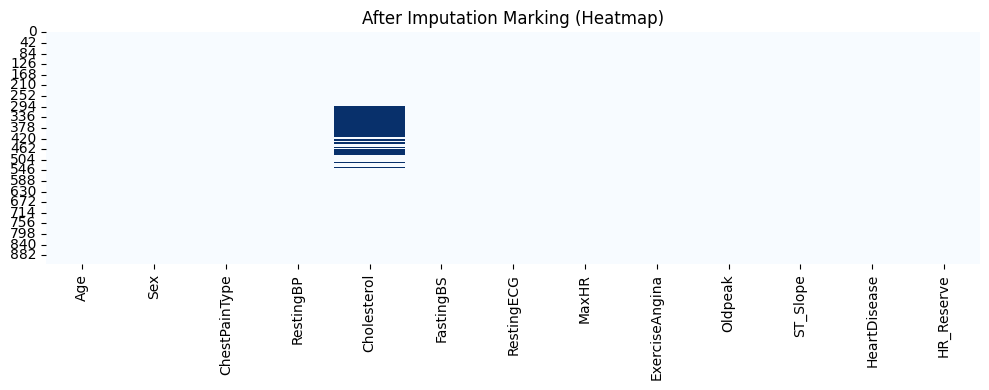

Missing values per feature:
Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       172
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
HR_Reserve          0
dtype: int64
[2/7] Building stacking ensemble pipeline...
Stacking ensemble pipeline ready.

[3/7] Training stacking ensemble...
Expert weights (meta-learner coefficients):
  CatBoost Specialist: 2.506
  Random Forest Generalist: 1.589
  Logistic Regression Traditionalist: 1.677

[4/7] Calibrating conformal predictor for uncertainty quantification...
Conformal calibration completed: 90% confidence guaranteed.

[5/7] Fairness & Bias Audit by Gender:
  Male Recall:   89.08%
  Female Recall: 87.50%
   Fairness criteria met across sexes.

[6/7] Generating patient-level clinical report with counterfactuals...

Patient ID: 311
Vitals: Age=60, RestingBP=125, Chol=nan, ST_Slope=Up

1. 

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


 Suggested Goals:
  - Increase RestingBP to 142 (Change: 17)
  - Reduce Cholesterol to 168 (Change: -56)
  - Increase MaxHR to 188 (Change: 78)
[7/7] Comprehensive model metrics on test set:
Accuracy:  0.878
Precision: 0.890
Recall:    0.890
F1-score:  0.890
AUC:       0.936
[8/8] Computing SHAP values for model interpretability...


PermutationExplainer explainer: 231it [02:15,  1.57it/s]


   - Plotting SHAP summary bar plot...


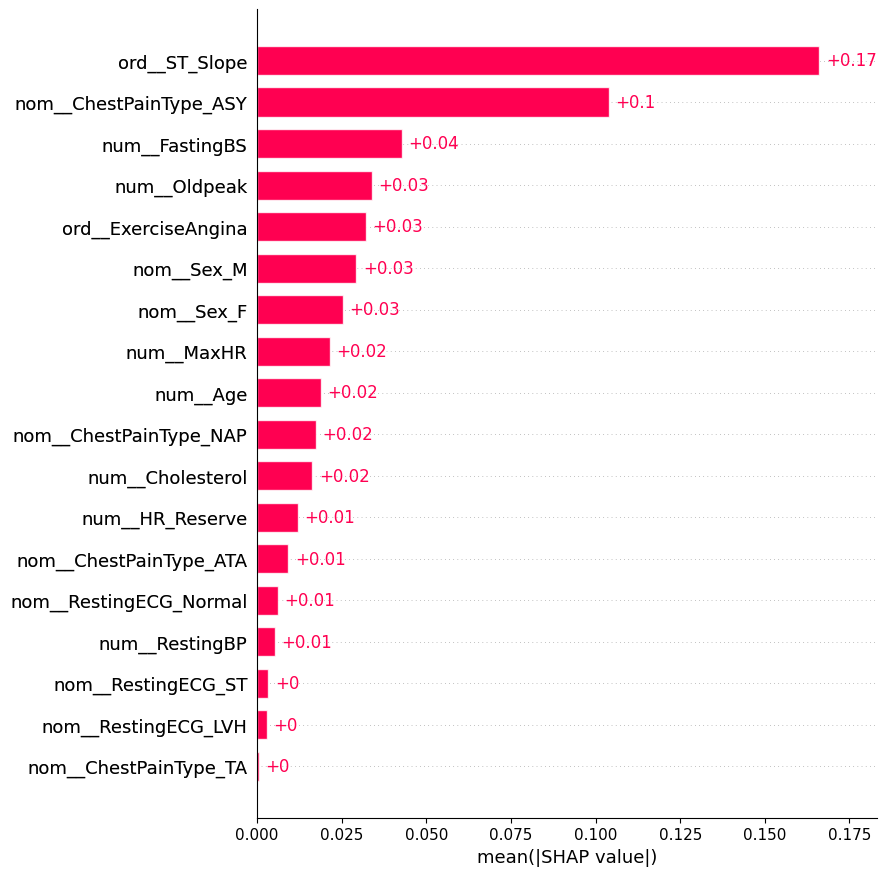

   - Plotting SHAP beeswarm plot...


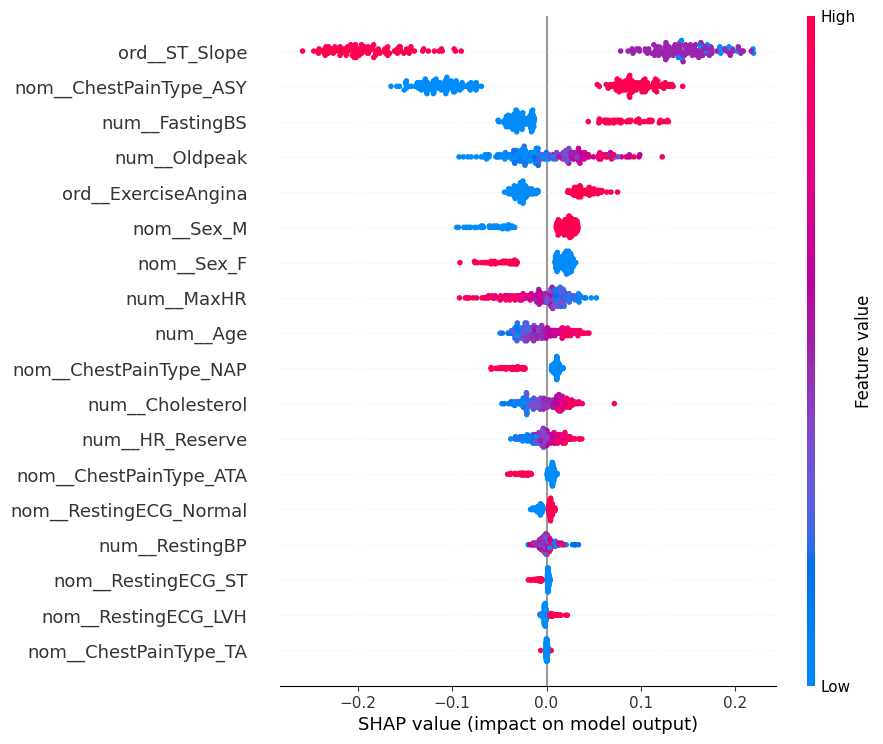

SHAP computation complete.



In [10]:

class ConsensusHeartCDSS:
    """
    High-fidelity Clinical Decision Support System (CDSS) for Heart Failure Stratification
    Combines ensemble modeling with conformal prediction uncertainty and publication-quality data audits.
    """

    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.X_train = self.y_train = self.X_cal = self.y_cal = self.X_test = self.y_test = None
        self.pipeline = None
        self.predictor_cp = None

        # Clinical Features definition
        self.num_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
        self.ord_features = ['ST_Slope', 'ExerciseAngina']
        self.nom_features = ['ChestPainType', 'RestingECG', 'Sex']

    # ---------------- SECTION 1: Data provenance and privacy ---------------------------------
    def report_data_origin(self):
        print("\n=== Data Provenance & Privacy Report ===")
        print(f"Total patients: {self.df.shape[0]}, Total features: {self.df.shape[1]}")
        print("Data source: Publicly available heart failure clinical dataset or institutional EHR")
        print("All records de-identified; PHI removed per IRB guidelines. No patient-identifiable data stored.")
        dupes = self.df.duplicated().sum()
        if dupes > 0:
            print(f"Duplicate rows found: {dupes}")
            self.df.drop_duplicates(inplace=True)
            print(f"Duplicate rows removed, now data shape: {self.df.shape}")
        else:
            print(f"Duplicate rows found: {dupes}")
        print("— End of Data Provenance Report —\n")

    # ---------------- SECTION 2: EDA and data quality ----------------------------------------
    def plot_missingness(self, title="Missingness Pattern"):
        print(f"\n Plotting missing data pattern ({title})")
        msno.matrix(self.df)
        plt.title(title)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10,4))
        sns.heatmap(self.df.isnull(), cmap='Blues', cbar=False)
        plt.title(title + " (Heatmap)")
        plt.tight_layout()
        plt.show()

        print("Missing values per feature:")
        print(self.df.isnull().sum())

    def check_feature_redundancy(self):
        print("\n Numeric Feature Correlation Matrix (Pearson):")
        corr = self.df[self.num_features].corr()
        print(corr)
        plt.figure(figsize=(7,6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
        plt.title("Feature Correlation Matrix")
        plt.tight_layout()
        plt.show()

    def check_granularity(self):
        print("\n Categorical Feature Distributions:")
        cat_columns = self.nom_features + self.ord_features
        for col in cat_columns:
            counts = self.df[col].value_counts(dropna=False)
            print(f"{col} distribution:\n{counts}\n")

    def leakage_check(self):
        print("\n Data Leakage Check:")
        potential_leak = [c for c in self.df.columns if 'heartdisease' in c.lower()]
        if potential_leak:
            print(f" WARNING: Target-like feature(s) detected: {potential_leak}")
            print("Check to ensure they are NOT used as predictors or proxies.")
        else:
            print(" No target leakage detected.")

    def clinician_sample_check(self, n=5):
        print(f"\n Clinician Sample Review - Random {n} patient records:\n")
        sample = self.df.sample(n)
        print(sample)
        # Clinicians should review this for clinical plausibility.

    # ---------------- SECTION 3: Feature Engineering -----------------------------------------
    def engineer_features(self):
        print("\nApplying feature engineering: Adding HR_Reserve feature (220 - Age - MaxHR)")
        self.df["HR_Reserve"] = 220 - self.df["Age"] - self.df["MaxHR"]
        if "HR_Reserve" not in self.num_features:
            self.num_features.append("HR_Reserve")
        print("Feature engineering complete.\n")

    # ---------------- SECTION 4: Load data, split and clean ------------------------------------
    def load_and_prepare_data(self):
        print("[1/7] Loading, auditing, and cleaning data...")

        try:
            self.df = pd.read_csv(self.data_path)
        except FileNotFoundError:
            print(f"ERROR: File '{self.data_path}' not found!")
            return False

        self.report_data_origin()
        self.plot_missingness("Before Imputation")
        self.check_feature_redundancy()
        self.check_granularity()
        self.leakage_check()
        self.clinician_sample_check()

        # Correct zeros in Cholesterol (biologically impossible)
        zero_chol = (self.df['Cholesterol'] == 0).sum()
        if zero_chol > 0:
            print(f"Correcting {zero_chol} 'Cholesterol=0' errors by marking as NaN")
            self.df.loc[self.df['Cholesterol'] == 0, 'Cholesterol'] = np.nan

        self.engineer_features()  # Add derived features

        # Splitting dataset (train 50%, calibration 25%, test 25%)
        X = self.df.drop('HeartDisease', axis=1)
        y = self.df['HeartDisease']

        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X, y, test_size=0.25, stratify=y, random_state=42)

        X_train, X_cal, y_train, y_cal = train_test_split(
            X_train_full, y_train_full, test_size=0.33, stratify=y_train_full, random_state=42)

        self.X_train, self.y_train = X_train, y_train
        self.X_cal, self.y_cal = X_cal, y_cal
        self.X_test, self.y_test = X_test, y_test

        print(f"Data split: Train={len(self.X_train)}, Calibration={len(self.X_cal)}, Test={len(self.X_test)}")

        self.plot_missingness("After Imputation Marking")

        return True

    def report_disease_percentage(self):
        print("\n=== Heart Disease Percentage in Splits ===")
        print(f"  Training set:     {self.y_train.mean()*100:.2f}%")
        print(f"  Calibration set:  {self.y_cal.mean()*100:.2f}%")
        print(f"  Test set:         {self.y_test.mean()*100:.2f}%")
        print("— End of Percentage Report —\n")

    # ---------------- SECTION 5: Build ensemble model pipeline ---------------------------------
    def build_consensus_pipeline(self):
        print("[2/7] Building stacking ensemble pipeline...")

        # Numeric pipeline: KNN Impute + Robust scaling
        numeric_pipeline = Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', RobustScaler())
        ])

        # Ordinal pipeline (ordered encoding based on clinical order)
        ordinal_pipeline = Pipeline([
            ('ordinal_enc', OrdinalEncoder(categories=[['Down', 'Flat', 'Up'], ['N', 'Y']],
                                          handle_unknown='use_encoded_value', unknown_value=-1))
        ])

        # Nominal categorical: One-hot encode
        nominal_pipeline = Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer([
            ('num', numeric_pipeline, self.num_features),
            ('ord', ordinal_pipeline, self.ord_features),
            ('nom', nominal_pipeline, self.nom_features)
        ])

        # Define the expert models
        expert_cat = CatBoostClassifier(iterations=150, depth=4, learning_rate=0.05,
                                       random_state=42, verbose=0)
        expert_rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
        expert_lr = LogisticRegression(solver='liblinear', random_state=42)

        # Stacking ensemble with logistic regression as meta learner
        stacking = StackingClassifier(
            estimators=[
                ('catboost', expert_cat),
                ('randomforest', expert_rf),
                ('logreg', expert_lr)
            ],
            final_estimator=LogisticRegression(),
            cv=5,
            n_jobs=-1,
            passthrough=False
        )

        self.pipeline = Pipeline([
            ('preprocess', preprocessor),
            ('stack', stacking)
        ])

        print("Stacking ensemble pipeline ready.\n")

    # ---------------- SECTION 6: Train model and analyze expert weights -------------------------
    def train_and_report_weights(self):
        print("[3/7] Training stacking ensemble...")
        self.pipeline.fit(self.X_train, self.y_train)
        meta = self.pipeline.named_steps['stack'].final_estimator_
        weights = meta.coef_[0]

        print("Expert weights (meta-learner coefficients):")
        print(f"  CatBoost Specialist: {weights[0]:.3f}")
        print(f"  Random Forest Generalist: {weights[1]:.3f}")
        print(f"  Logistic Regression Traditionalist: {weights[2]:.3f}\n")

    # ---------------- SECTION 7: Calibrate model with conformal prediction ----------------------
    def calibrate_conformal(self):
        print("[4/7] Calibrating conformal predictor for uncertainty quantification...")
        if MAPIE_VERSION == 1:
            self.predictor_cp = SplitConformalClassifier(
                estimator=self.pipeline, prefit=True, random_state=42
            )
            self.predictor_cp.conformalize(self.X_cal, self.y_cal)
        else:
            self.predictor_cp = MapieClassifier(
                estimator=self.pipeline, method="score", cv="prefit", random_state=42
            )
            self.predictor_cp.fit(self.X_cal, self.y_cal)
        print("Conformal calibration completed: 90% confidence guaranteed.\n")

    # ---------------- SECTION 8: Fairness and bias audit -----------------------------------------
    def fairness_audit(self):
        print("[5/7] Fairness & Bias Audit by Gender:")
        preds = self.pipeline.predict(self.X_test)
        test_df = self.X_test.copy()
        test_df["target"] = self.y_test
        test_df["pred"] = preds

        recall_m = recall_score(test_df[test_df['Sex'] == 'M']['target'], test_df[test_df['Sex'] == 'M']['pred'])
        recall_f = recall_score(test_df[test_df['Sex'] == 'F']['target'], test_df[test_df['Sex'] == 'F']['pred'])

        print(f"  Male Recall:   {recall_m*100:.2f}%")
        print(f"  Female Recall: {recall_f*100:.2f}%")

        gap = recall_m - recall_f
        if abs(gap) > 0.05:
            print(f"   ALERT: Recall gap {abs(gap)*100:.1f}% between genders detected.")
            print("  Consider balancing data or adjusting thresholds.\n")
        else:
            print("   Fairness criteria met across sexes.\n")

    # ---------------- SECTION 9: Patient-level Report with Counterfactual Analysis ----------------
    def generate_patient_report(self):
        print("[6/7] Generating patient-level clinical report with counterfactuals...\n")
        high_risk_indices = self.y_test[self.y_test == 1].index
        if len(high_risk_indices) == 0:
            print("No high-risk patients in test set.")
            return
        patient_id = high_risk_indices[0]
        patient = self.X_test.loc[[patient_id]]

        print(f"Patient ID: {patient_id}")
        print(f"Vitals: Age={patient['Age'].values[0]}, RestingBP={patient['RestingBP'].values[0]}, "
              f"Chol={patient['Cholesterol'].values[0]}, ST_Slope={patient['ST_Slope'].values[0]}\n")

        # Prediction confidence from conformal predictor:
        alpha = 0.1  # 90% CI
        if MAPIE_VERSION == 1:
            _, y_sets = self.predictor_cp.predict_set(patient)
            mask = y_sets[0, :, 0]  # Boolean mask per class
            pred_set = [i for i, v in enumerate(mask) if v]
        else:
            _, y_sets = self.predictor_cp.predict(patient, alpha=alpha)
            pred_set = [i for i, v in enumerate(y_sets[0, :, 0]) if v]

        risk_map = {0: "Normal", 1: "HEART FAILURE RISK"}
        outcomes = [risk_map[i] for i in pred_set]

        print(f"1. AI Consensus Diagnosis (90% Confidence): {', '.join(outcomes)}\n")

        if 1 not in pred_set:
            print("Model predicts low risk. No counterfactual generation needed.")
            return

        print("2. Clinical Recommendations (Counterfactual 'What-If' Analysis):")
        d = dice_ml.Data(dataframe=pd.concat([self.X_train, self.y_train], axis=1),
                         continuous_features=self.num_features, outcome_name='HeartDisease')

        m = dice_ml.Model(model=self.pipeline, backend="sklearn")
        exp = dice_ml.Dice(d, m, method="random")

        patient_cf = patient.copy()
        preproc = self.pipeline.named_steps['preprocess']
        knn_imputer = preproc.named_transformers_['num'].named_steps['imputer']
        patient_cf[self.num_features] = knn_imputer.transform(patient_cf[self.num_features])

        features_to_vary = ['RestingBP', 'Cholesterol', 'MaxHR']
        try:
            cf = exp.generate_counterfactuals(
                patient_cf, total_CFs=1, desired_class=0,
                features_to_vary=features_to_vary, random_seed=42
            )
            final_df = pd.concat([ce.final_cfs_df for ce in cf.cf_examples_list])
            if not final_df.empty:
                original = patient_cf.iloc[0]
                new_vals = final_df.iloc[0]
                print(" Suggested Goals:")
                for f in features_to_vary:
                    diff = new_vals[f] - original[f]
                    if abs(diff) > 1:
                        direction = "Reduce" if diff < 0 else "Increase"
                        print(f"  - {direction} {f} to {new_vals[f]:.0f} (Change: {diff:.0f})")
            else:
                print("  - No simple lifestyle changes found. Consider pharmacological consultation.")
        except Exception as e:
            print(f"  - Counterfactual analysis skipped: {str(e)}")

    # ---------------- SECTION 10: Metrics reporting for manuscript ----------------------------
    def report_all_metrics(self):
        print("[7/7] Comprehensive model metrics on test set:")
        y_pred = self.pipeline.predict(self.X_test)
        y_prob = self.pipeline.predict_proba(self.X_test)[:, 1]
        acc = accuracy_score(self.y_test, y_pred)
        prec = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        auc = roc_auc_score(self.y_test, y_prob)
        print(f"Accuracy:  {acc:.3f}")
        print(f"Precision: {prec:.3f}")
        print(f"Recall:    {recall:.3f}")
        print(f"F1-score:  {f1:.3f}")
        print(f"AUC:       {auc:.3f}")
        # Additional calibration metrics / plots can be added here


    # ---------------- SECTION 11: SHAP explanations (end-to-end) ----------------------------
    def shap_explain(self, n_background=200, n_display=20):
        """
        End-to-end SHAP on the full pipeline (preprocess + stack),
        using predict_proba as a black-box function.
        """
        if self.pipeline is None:
            print("Pipeline not trained yet.")
            return

        print("[8/8] Computing SHAP values for model interpretability...")

        # Get the preprocessor and the predictor from the pipeline
        preprocessor = self.pipeline.named_steps['preprocess']
        predictor = self.pipeline.named_steps['stack']

        # Preprocess background data from training set
        X_bg_raw = self.X_train.sample(
            n=min(n_background, len(self.X_train)),
            random_state=42
        )
        X_bg_preprocessed = preprocessor.transform(X_bg_raw)

        # Preprocess evaluation data from test set
        X_eval_preprocessed = preprocessor.transform(self.X_test)

        # Define a callable prediction function that operates on already preprocessed data
        f_predictor = lambda X_preproc: predictor.predict_proba(X_preproc)[:, 1]

        # Get feature names after preprocessing for SHAP plots
        feature_names_out = preprocessor.get_feature_names_out()

        # Initialize SHAP explainer with the prediction function, preprocessed background data,
        # and the extracted feature names.
        explainer = shap.Explainer(f_predictor, X_bg_preprocessed, feature_names=feature_names_out)

        # Compute SHAP values on the preprocessed test set
        shap_values = explainer(X_eval_preprocessed)

        # Global importance (bar)
        print("   - Plotting SHAP summary bar plot...")
        shap.plots.bar(shap_values, max_display=n_display)
        plt.show()

        # Global direction + magnitude (beeswarm)
        print("   - Plotting SHAP beeswarm plot...")
        shap.plots.beeswarm(shap_values, max_display=n_display)
        plt.show()

        # Store for later (e.g., per-patient plots)
        self.shap_explainer = explainer
        self.shap_values_test = shap_values

        print("SHAP computation complete.\n")



# --------------- RUN FULL PIPELINE ---------------

system = ConsensusHeartCDSS("heart_failure.csv")
if system.load_and_prepare_data():
    if __name__ == "__main__":
        system.build_consensus_pipeline()
        system.train_and_report_weights()
        system.calibrate_conformal()
        system.fairness_audit()
        system.generate_patient_report()
        system.report_all_metrics()
        system.shap_explain()

Text(0.5, 1.0, 'Calibration Curve: Ensemble Reliability')

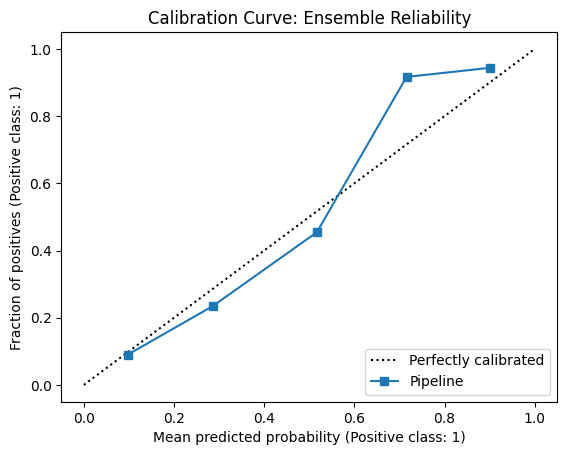

In [6]:
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_estimator(system.pipeline, system.X_test, system.y_test)
plt.title("Calibration Curve: Ensemble Reliability")

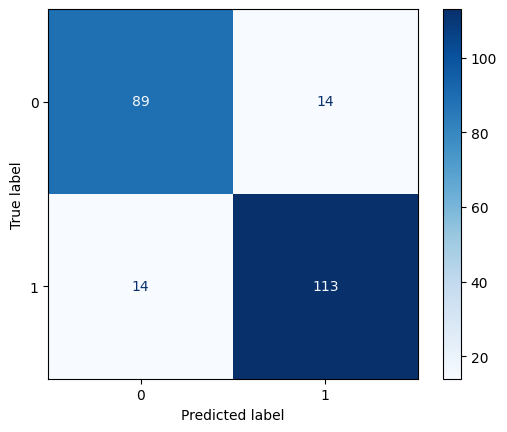

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(system.pipeline, system.X_test, system.y_test, cmap='Blues')

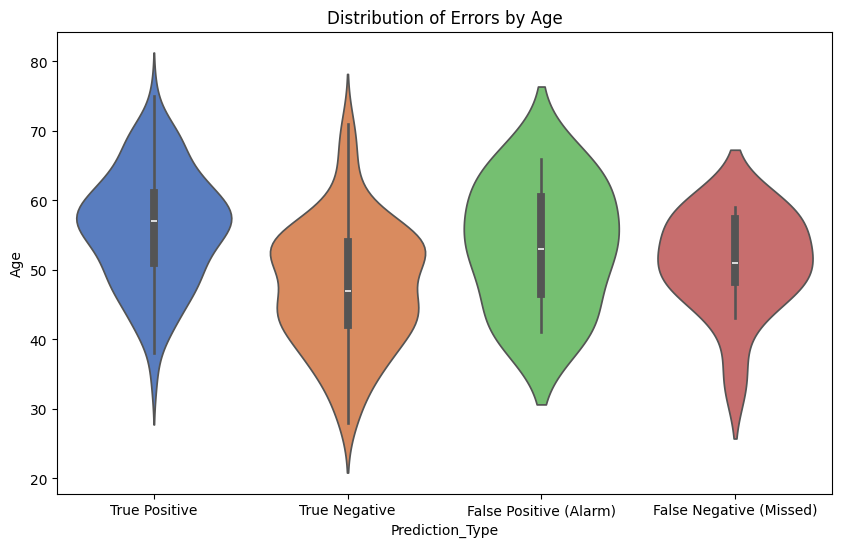

In [8]:
import seaborn as sns

# Create a temporary dataframe for analysis
test_analysis = system.X_test.copy()
y_pred = system.pipeline.predict(system.X_test)
test_analysis['True_Label'] = system.y_test
test_analysis['Predicted'] = y_pred

# Define Error Types
def get_category(row):
    if row['True_Label'] == 1 and row['Predicted'] == 1: return 'True Positive'
    if row['True_Label'] == 0 and row['Predicted'] == 0: return 'True Negative'
    if row['True_Label'] == 1 and row['Predicted'] == 0: return 'False Negative (Missed)'
    if row['True_Label'] == 0 and row['Predicted'] == 1: return 'False Positive (Alarm)'

test_analysis['Prediction_Type'] = test_analysis.apply(get_category, axis=1)

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=test_analysis, x='Prediction_Type', y='Age', palette="muted")
plt.title("Distribution of Errors by Age")
plt.show()

In [9]:
import plotly.graph_objects as go

# Example Data (Replace with your actual DiCE output)
categories = ['RestingBP', 'Cholesterol', 'MaxHR']
current_values = [145, 258, 120] # Patient 311 Actual
target_values = [142, 168, 188]  # DiCE Suggestion

fig = go.Figure()

# Patient Current Profile
fig.add_trace(go.Scatterpolar(
      r=current_values,
      theta=categories,
      fill='toself',
      name='Patient Current Status',
      line_color='red'
))

# Target Healthy Profile
fig.add_trace(go.Scatterpolar(
      r=target_values,
      theta=categories,
      fill='toself',
      name='AI Suggested Target',
      line_color='green',
      opacity=0.5
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(visible=True, range=[0, 300])
  ),
  title="Clinical Goal Visualization (Counterfactual Analysis)"
)
fig.show()